In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
train = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
test = pd.read_csv("../input/tensorflow-great-barrier-reef/test.csv")
# ss = pd.read_csv("../input/tensorflow-great-barrier-reef/example_sample_submission.csv")

train.shape, test.shape

((23501, 6), (3, 5))

In [3]:
def resumetable(df):
    '''function to create feature summary'''
    print(f'Shape: {df.shape}')z
    summary = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'Features'})
    summary['Num of Null Value'] = df.isnull().sum().values
    summary['Num of Unique Value'] = df.nunique().values
    summary['1st Value'] = df.loc[0].values
    summary['2nd Value'] = df.loc[1].values
    summary['3rd Value'] = df.loc[2].values
    return summary

# 簡単なtrainの統計量
- データ総数23501枚
に対しannotationのuniqueが4914枚
-　そのうちアノテ無しが18582枚

In [4]:
resumetable(train)

Shape: (23501, 6)


,Features,Data Type,Num of Null Value,Num of Unique Value,1st Value,2nd Value,3rd Value
0,video_id,int64,0,3,0,0,0
1,sequence,int64,0,20,40258,40258,40258
2,video_frame,int64,0,10688,0,1,2
3,sequence_frame,int64,0,2988,0,1,2
4,image_id,object,0,23501,0-0,0-1,0-2
5,annotations,object,0,4914,[],[],[]


In [5]:
train.query('annotations=="[]"').count()

video_id          18582
sequence          18582
video_frame       18582
sequence_frame    18582
image_id          18582
annotations       18582
dtype: int64

In [6]:
train['annotations'] = train['annotations'].apply(lambda x: eval(x)) # annotationsが文字列として入っているため、eval()

# とりあえず調べる
- bounding box面積の分布（全bounding box, 各画像平均)
- 画像枚ラベル数の分布

In [7]:
def calc_areas(box_list):
    area_list = []
    for box_dict in box_list:
        x = box_dict['width']
        y = box_dict['height']
        area_list.append(x * y)
    return area_list

train['n_annotations'] = train['annotations'].apply(lambda x: len(x))
train['annotation_areas'] = train['annotations'].apply(calc_areas)
train['annotation_areas_mean'] = train['annotation_areas'].apply(np.mean)
# train['annotation_areas_mean'] = train['annotation_areas_mean'].fillna(0)

/Users/ryota_osaki/opt/miniconda3/envs/basic_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [8]:
train

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,n_annotations,annotation_areas,annotation_areas_mean
0,0,40258,0,0,0-0,[],0,[],NaN
1,0,40258,1,1,0-1,[],0,[],NaN
2,0,40258,2,2,0-2,[],0,[],NaN
3,0,40258,3,3,0-3,[],0,[],NaN
4,0,40258,4,4,0-4,[],0,[],NaN
...,...,...,...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[],0,[],NaN
23497,2,29859,10756,2984,2-10756,[],0,[],NaN
23498,2,29859,10757,2985,2-10757,[],0,[],NaN
23499,2,29859,10758,2986,2-10758,[],0,[],NaN


- アノテーション座標・面積の集計

In [9]:
def summary_list(target_list: list, label: str):
    all_count = len(target_list)
    unique_rate = len(np.unique(target_list)) / all_count
    print(f'ALL COUNT {label}:  {all_count}')
    print(f'UNIQUE RATE {label}:  {unique_rate}')
    print(f'DESCRIBE {label}\n', pd.Series(target_list).describe())


    fig, ax = plt.subplots()
    sns.histplot(data=target_list, bins=int(len(target_list)/100), ax=ax)
    ax.set_title(f'Distribution of {label}', weight='bold')
    plt.show()

In [10]:
# アノテーション単位（not 画像単位）の分布を確認する
x_list = []
y_list = []
width_list = []
height_list = []
area_list = []
for item in train.iterrows():
    for _annotate, _area in zip(item[1]['annotations'], item[1]['annotation_areas']):
        x_list.append(_annotate['x'])
        y_list.append(_annotate['y'])
        width_list.append(_annotate['width'])
        height_list.append(_annotate['height'])
        area_list.append(_area)


ALL COUNT x:  11898
UNIQUE RATE x:  0.10085728693898134
DESCRIBE x
 count    11898.000000
mean       490.038578
std        274.052305
min          0.000000
25%        278.000000
50%        477.000000
75%        664.000000
max       1244.000000
dtype: float64


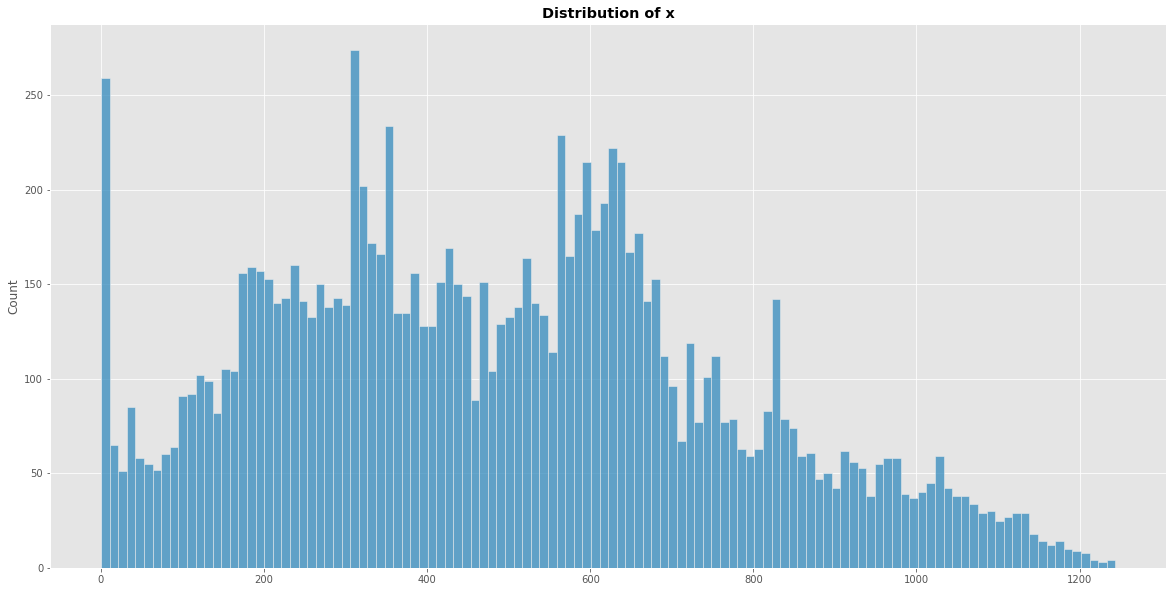

ALL COUNT y:  11898
UNIQUE RATE y:  0.059337703815767355
DESCRIBE y
 count    11898.000000
mean       346.267944
std        185.139016
min          0.000000
25%        198.000000
50%        346.000000
75%        493.750000
max        706.000000
dtype: float64


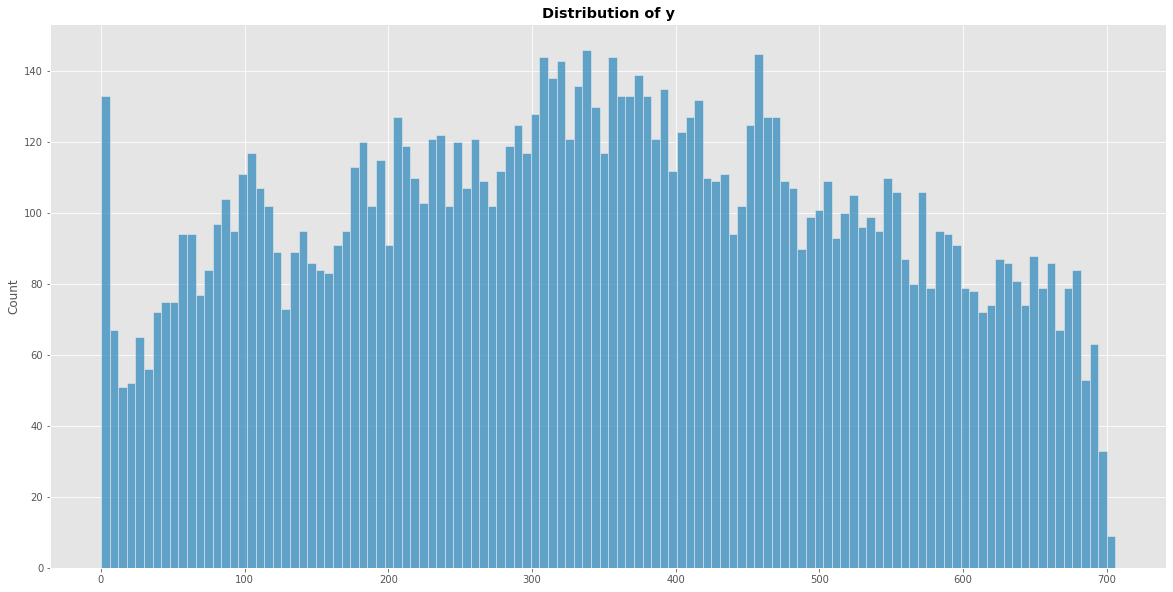

ALL COUNT width:  11898
UNIQUE RATE width:  0.011178349302403766
DESCRIBE width
 count    11898.000000
mean        47.885443
std         17.448619
min         17.000000
25%         35.000000
50%         45.000000
75%         57.000000
max        243.000000
dtype: float64


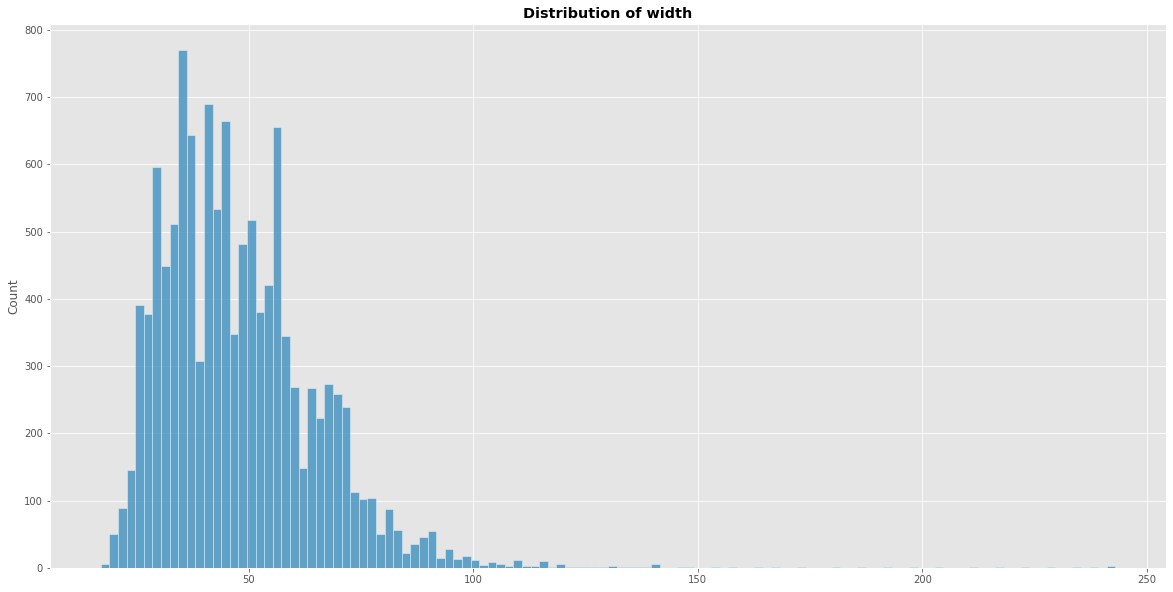

ALL COUNT height:  11898
UNIQUE RATE height:  0.009833585476550681
DESCRIBE height
 count    11898.000000
mean        42.723231
std         15.379084
min         13.000000
25%         32.000000
50%         40.000000
75%         52.000000
max        222.000000
dtype: float64


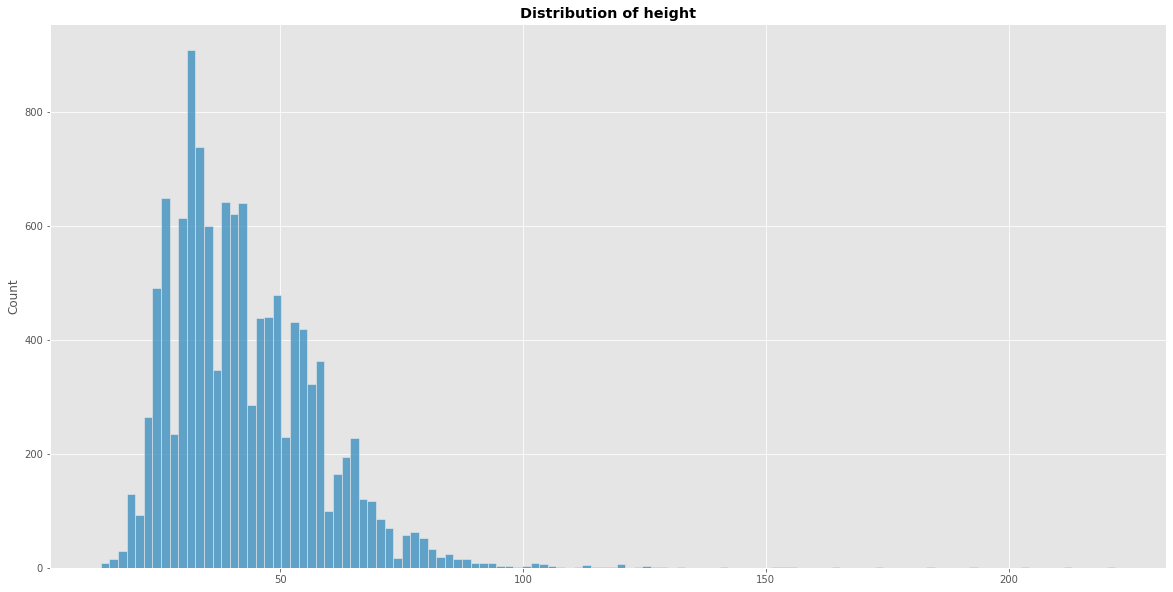

ALL COUNT area:  11898
UNIQUE RATE area:  0.11943183728357708
DESCRIBE area
 count    11898.000000
mean      2259.660699
std       1973.017724
min        288.000000
25%       1155.000000
50%       1786.000000
75%       2907.000000
max      52170.000000
dtype: float64


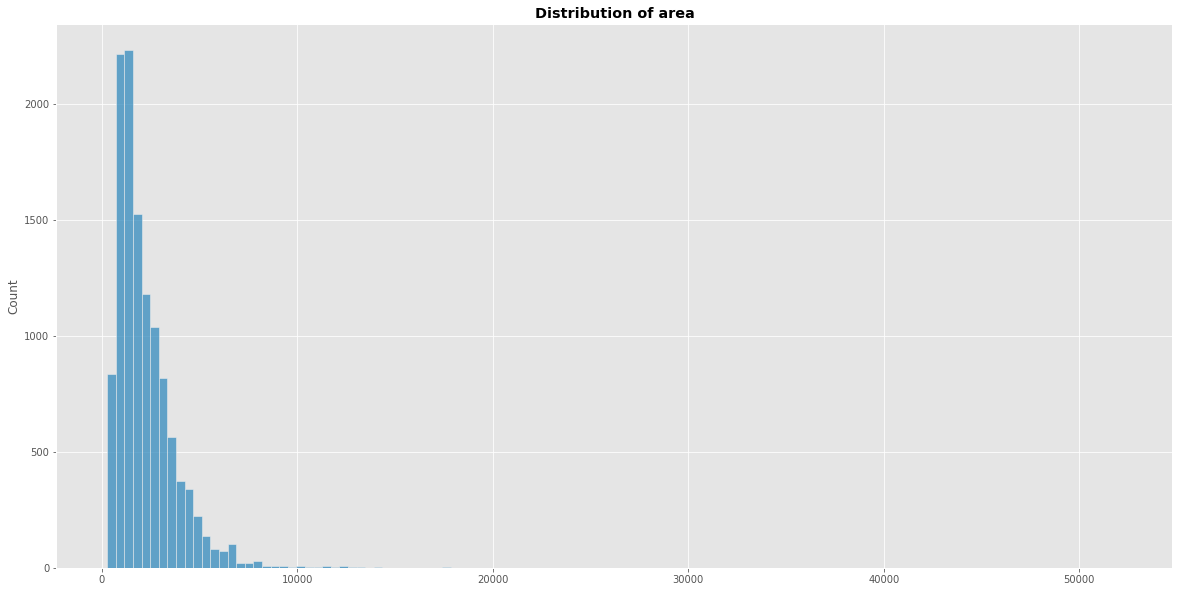

In [11]:
for _target, _label in zip([x_list , y_list, width_list, height_list, area_list], ['x', 'y', 'width', 'height', 'area']):
    summary_list(_target, _label)

- 画像毎アノテ数の分布

ALL COUNT n_label:  23501
UNIQUE RATE n_label:  0.0008084762350538275
DESCRIBE n_label
 count    23501.000000
mean         0.506276
std          1.637906
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: n_annotations, dtype: float64


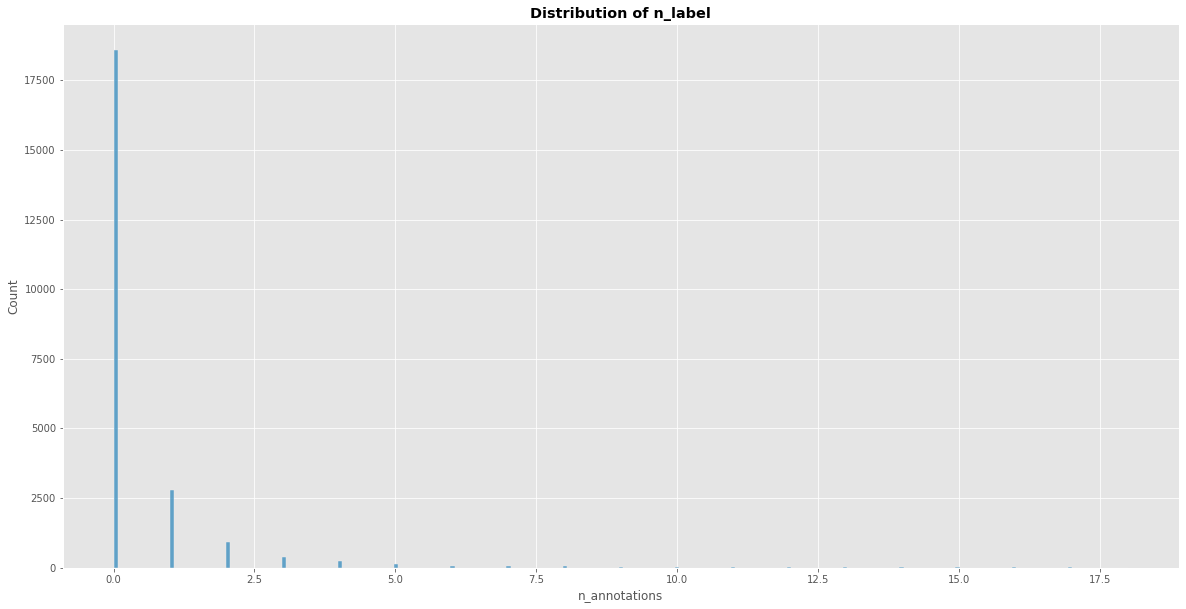

In [12]:
summary_list(train['n_annotations'], 'n_label')

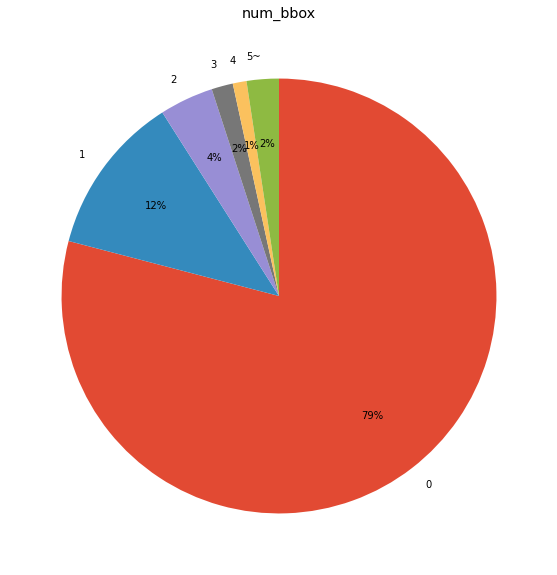

In [13]:
df = train["n_annotations"].value_counts(normalize=True).sort_values(ascending=False)[:5]*100
df["5~"]=train["n_annotations"].value_counts(normalize=True).sort_values(ascending=False)[5:].sum()*100
df_labels = df.index
plt.pie(df,startangle = 90,counterclock = False,labels = df_labels,autopct="%1.0f%%",pctdistance=0.7)
plt.title("num_bbox")

plt.show()

- 画像枚boundingbox面積の平均分布

ALL COUNT areas_mean:  23501
UNIQUE RATE areas_mean:  0.8926854176418024
DESCRIBE areas_mean
 count     4919.000000
mean      2357.412592
std       2527.037058
min        324.000000
25%       1190.000000
50%       1790.866667
75%       2880.666667
max      52170.000000
Name: annotation_areas_mean, dtype: float64


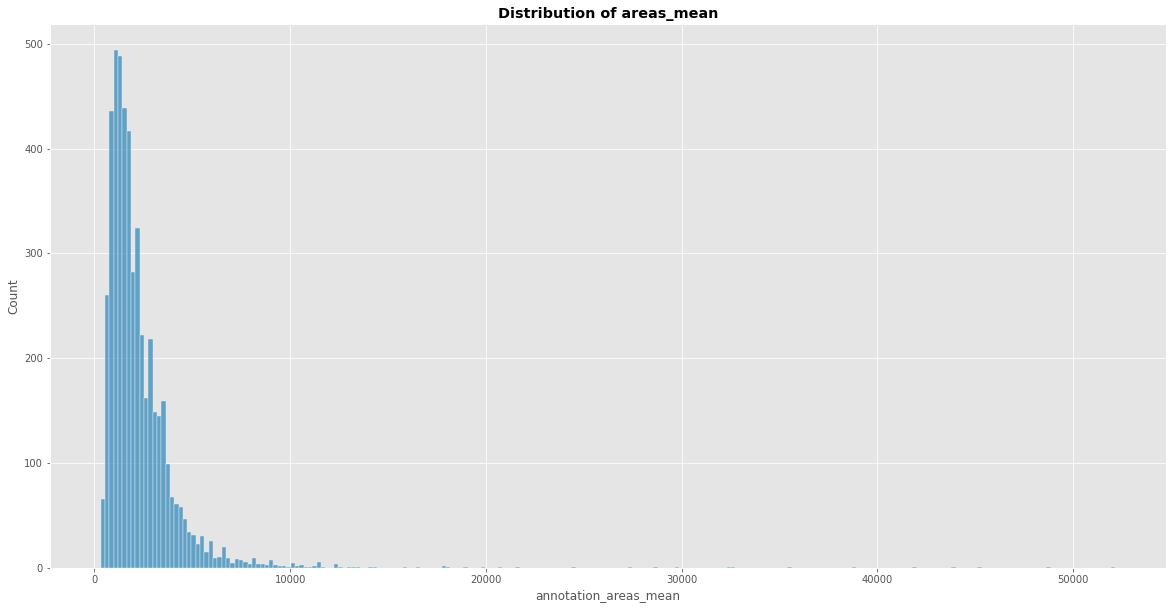

In [14]:
summary_list(train['annotation_areas_mean'], 'areas_mean')

In [15]:
243*706

171558

In [17]:
sr = pd.Series(["1", None, "2"])

In [18]:
sr

0       1
1    None
2       2
dtype: object

In [19]:
[_ is None for _ in hikari_series["K_OR_H"]]

[False, True, False]

In [20]:
sr is None

False